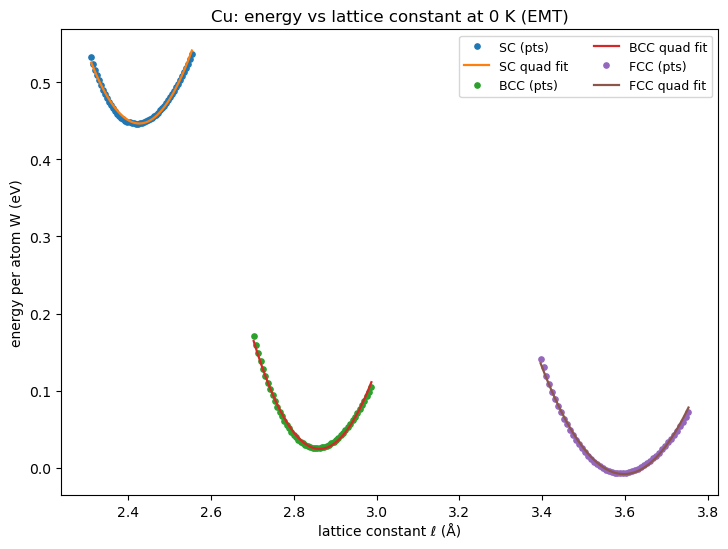

Quadratic fit in a fine window:  W(ℓ) = p0 + p1 ℓ + p2 ℓ^2   (energies in eV, ℓ in Å)
Struct          p0          p1          p2    ℓ0_q (Å) W0_q (eV/atom)
SC       34.937765  -28.428586    5.857862      2.4265      0.446322
BCC      45.184985  -31.556721    5.512708      2.8622      0.024481
FCC      45.829728  -25.480980    3.541178      3.5978     -0.008151

Lowest-energy structure (EMT): FCC with ℓ0 ≈ 3.5978 Å.
Literature ~3.615 Å: Δ = -0.0172 Å (-0.48%).


In [48]:
# Task 3.2

import numpy as np
import matplotlib.pyplot as plt

from ase.build import bulk
from ase.calculators.emt import EMT

# Inputs and starting parameters
radius_pm = 128.0          # atomic radius a for Cu in pm
r_A = radius_pm * 0.01     # Å

# geometry-based guesses from (closest-packed arguments)
l_guess = {
    'sc' : 2.0 * r_A,                   # ℓ ≈ 2 a
    'bcc': 4.0 * r_A / np.sqrt(3.0),
    'fcc': 2.0 * np.sqrt(2.0) * r_A
}

# coarse scan settings (to bracket the minimum reliably)
coarse_rel_span = 0.15     # ±15% around guess
coarse_npoints  = 25

# fine window (local refinement around the best coarse point)
fine_rel_span = 0.05       # ±5% around the coarse minimum
fine_npoints  = 51

# Define arrays L (Å), W_per_atom (eV) for given cubic structure
def energy_vs_lattice(structure, element='Cu', l0=None, rel_span=0.15, n=15):
    """
    Sample total energy and per-atom energy for a cubic structure over a range of 'a' (Å).
    """
    if l0 is None:
        raise ValueError("Provide an initial lattice guess l0 (Å).")
    L = np.linspace((1-rel_span)*l0, (1+rel_span)*l0, n)
    E = np.zeros_like(L)
    V = np.zeros_like(L)
    N = None
    for i, l in enumerate(L):
        atoms = bulk(element, structure, a=l, cubic=True)
        atoms.calc = EMT()
        E[i] = atoms.get_potential_energy()  # eV total
        V[i] = atoms.get_volume()            # Å^3
        if N is None:
            N = len(atoms)
    W = E / N                                # eV/atom
    return L, E, W, V, N

# Fit W(ℓ) = p0 + p1 ℓ + p2 ℓ^2.
def fit_quadratic(L, W):
    p2, p1, p0 = np.polyfit(L, W, deg=2)
    lmin = -p1 / (2.0 * p2)
    Wmin = p0 + p1*lmin + p2*lmin*lmin
    return (p0, p1, p2), lmin, Wmin

results = {}
plt.figure(figsize=(7.4, 5.6))

# Loop using the starting parameters
for struct, l0 in l_guess.items():
    # Coarse scan to bracket the minimum
    Lc, Ec, Wc, Vc, N = energy_vs_lattice(struct, 'Cu', l0=l0,
                                          rel_span=coarse_rel_span, n=coarse_npoints)
    l_center = Lc[np.argmin(Wc)]

    # Fine scan near the minimum (better conditioning of quadratic fit)
    Lf, Ef, Wf, Vf, _ = energy_vs_lattice(struct, 'Cu', l0=l_center,
                                          rel_span=fine_rel_span, n=fine_npoints)

    # Quadratic fit
    (p0, p1, p2), lmin_q, Wmin_q = fit_quadratic(Lf, Wf)

    # Record
    results[struct] = dict(
        p0=p0, p1=p1, p2=p2,
        lmin_q=lmin_q, Wmin_q=Wmin_q,
        L=Lc, W=Wc, Lf=Lf, Wf=Wf
    )

    # Plot: points + local quadratic fit
    plt.plot(Lf, Wf, 'o', ms=3.8, label=f'{struct.upper()} (pts)')
    Lfit = np.linspace(Lf.min(), Lf.max(), 300)
    Wfit = p0 + p1*Lfit + p2*(Lfit**2)
    plt.plot(Lfit, Wfit, '-', lw=1.6, label=f'{struct.upper()} quad fit')

plt.xlabel('lattice constant ℓ (Å)')
plt.ylabel('energy per atom W (eV)')
plt.title('Cu: energy vs lattice constant at 0 K (EMT)')
plt.legend(loc='best', ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# Summary table
print("Quadratic fit in a fine window:  W(ℓ) = p0 + p1 ℓ + p2 ℓ^2   (energies in eV, ℓ in Å)")
print("{:<6s} {:>11s} {:>11s} {:>11s}   {:>9s} {:>13s}".format(
    "Struct", "p0", "p1", "p2", "ℓ0_q (Å)", "W0_q (eV/atom)"))

for struct in ("sc","bcc","fcc"):
    r = results[struct]
    print("{:<6s} {:>11.6f} {:>11.6f} {:>11.6f}   {:>9.4f} {:>13.6f}".format(
        struct.upper(), r['p0'], r['p1'], r['p2'], r['lmin_q'], r['Wmin_q']))

# Compare best lattice to literature (~0 K copper ≈ 3.615 Å)
best_struct = min(results, key=lambda k: results[k]['Wmin_q'])
best_l0 = results[best_struct]['lmin_q']
lit = 3.615  # Å
err_pct = (best_l0 - lit)/lit*100
print(f"\nLowest-energy structure (EMT): {best_struct.upper()} with ℓ0 ≈ {best_l0:.4f} Å.")
print(f"Literature ~{lit:.3f} Å: Δ = {best_l0 - lit:+.4f} Å ({err_pct:+.2f}%).")


fcc Cu @ 0 K (EMT) — Elastic constants via energy–strain fits
Units: 10^11 N/m^2 (Table 1)  — reference values in parentheses.

C11 =   1.7166   (ref 1.7620)   err =  -2.58%
C12 =   1.1617   (ref 1.2494)   err =  -7.02%
C44 =   0.8684   (ref 0.8177)   err =  +6.21%


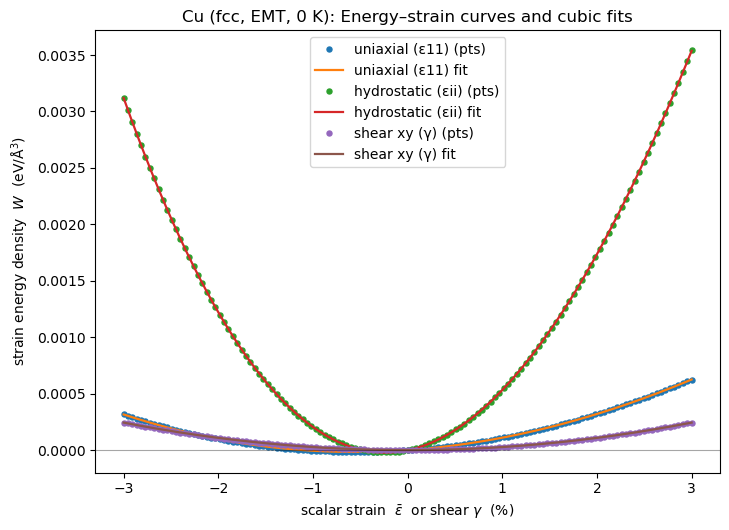

In [46]:
# Task 3.5
from ase.optimize import BFGS

# Cubic fit and derivatives
def fit_cubic(x, y):
    """
    Fit y(x) ~ a x^3 + b x^2 + c x + d and return coefficients,
    the stationary point nearest x=0, and the second derivative there.
    """
    a, b, c, d = np.polyfit(x, y, deg=3)
    roots = np.roots([3*a, 2*b, c])                 # y' = 3 a x^2 + 2 b x + c
    real_roots = roots[np.isreal(roots)].real
    x_min = real_roots[np.argmin(np.abs(real_roots))] if len(real_roots) else 0.0
    d2y = 6*a*x_min + 2*b                            # y''(x_min)
    return (a, b, c, d), x_min, d2y

def deform_cell(cell0, eps):
    # new_cell = cell0 @ (I + eps)
    return cell0 @ (np.eye(3) + eps)

# Reference fcc state from Task 3.2
if 'fcc' not in results:
    raise RuntimeError("Task 3.2 results not found. Run the first cell to create `results['fcc']`.")

l0 = results['fcc'].get('lmin_c', results['fcc']['lmin_q'])

# Build relaxed reference at l0, then positions-only relax
atoms0 = bulk('Cu', 'fcc', a=l0, cubic=True)
atoms0.calc = EMT()

dyn0 = BFGS(atoms0, logfile=None)
dyn0.run(fmax=1e-6, steps=200)

E0 = atoms0.get_potential_energy()   # eV (total)
V0 = atoms0.get_volume()             # Å^3
cell0 = atoms0.get_cell().array.copy()

# Strain paths
# Path A (uniaxial): epsilon = diag(eps, 0, 0)  -> d2W/dε^2 = C11
def eps_uniax(eps):
    M = np.zeros((3,3)); M[0,0] = eps; return M

# Path B (hydrostatic): epsilon = diag(eps, eps, eps) -> d2W/dε^2 = 3 (C11 + 2 C12)
def eps_hydro(eps):
    M = np.zeros((3,3)); M[0,0] = eps; M[1,1] = eps; M[2,2] = eps; return M

# Path C (simple shear γ in xy): ε12 = γ/2, ε21 = γ/2  -> d2W/dγ^2 = C44
def eps_shear_xy(gamma):
    M = np.zeros((3,3)); M[0,1] = 0.5*gamma; M[1,0] = 0.5*gamma; return M

paths = {
    "uniaxial (ε11)": eps_uniax,
    "hydrostatic (εii)": eps_hydro,
    "shear xy (γ)": eps_shear_xy
}

# Sampling (small strains in elastic regime)
span  = 0.03    # ±1.0%
npts  = 131
grid  = np.linspace(-span, span, npts)

curves = {}
for label, eps_fun in paths.items():
    X, W = [], []
    for s in grid:
        # fresh copy each time
        atoms = bulk('Cu', 'fcc', a=l0, cubic=True)
        atoms.calc = EMT()
        # affine cell deformation and consistent scaling of positions
        new_cell = deform_cell(cell0, eps_fun(s))
        atoms.set_cell(new_cell, scale_atoms=True)
        E = atoms.get_potential_energy()
        W.append((E - E0) / V0)   # strain energy density (eV/Å^3)
        X.append(s)

    X = np.array(X); W = np.array(W)
    curves[label] = (X, W)

# Fit cubic, extract curvatures, compose elastic constants
fits = {}
for label, (X, W) in curves.items():
    (a,b,c,d), x_min, d2W = fit_cubic(X, W)
    fits[label] = dict(a=a,b=b,c=c,d=d, x_min=x_min, d2W=d2W)

# From derivations:
#   Path A: d2W = C11
C11_eVA3 = fits["uniaxial (ε11)"]["d2W"]
#   Path B: d2W = 3 (C11 + 2 C12)  → C12 = ( d2W_B / 3 - C11 ) / 2
d2W_hyd  = fits["hydrostatic (εii)"]["d2W"]
C12_eVA3 = (d2W_hyd / 3.0 - C11_eVA3) / 2.0
#   Path C: d2W = C44
C44_eVA3 = fits["shear xy (γ)"]["d2W"]

# Convert eV/Å^3 → 10^11 N/m^2
conv = 1.6021766208
C11 = C11_eVA3 * conv
C12 = C12_eVA3 * conv
C44 = C44_eVA3 * conv

# Literature @ 0 K (units: 10^11 N/m^2)
C11_lit, C12_lit, C44_lit = 1.7620, 1.2494, 0.8177
pct_err = lambda val, ref: (val - ref)/ref * 100.0

print("fcc Cu @ 0 K (EMT) — Elastic constants via energy–strain fits")
print("Units: 10^11 N/m^2 (Table 1)  — reference values in parentheses.\n")
print(f"C11 = {C11:8.4f}   (ref {C11_lit:.4f})   err = {pct_err(C11, C11_lit):+6.2f}%")
print(f"C12 = {C12:8.4f}   (ref {C12_lit:.4f})   err = {pct_err(C12, C12_lit):+6.2f}%")
print(f"C44 = {C44:8.4f}   (ref {C44_lit:.4f})   err = {pct_err(C44, C44_lit):+6.2f}%")

# Plots
plt.figure(figsize=(7.4, 5.4))
for label, (X, W) in curves.items():
    a,b,c,d = fits[label]['a'], fits[label]['b'], fits[label]['c'], fits[label]['d']
    xx = np.linspace(X.min(), X.max(), 500)
    yy = a*xx**3 + b*xx**2 + c*xx + d
    plt.plot(X*100, W, 'o', ms=3.6, label=f"{label} (pts)")
    plt.plot(xx*100, yy, '-', lw=1.6, label=f"{label} fit")
plt.axhline(0, lw=0.8, color='k', alpha=0.35)
plt.xlabel("scalar strain  $\\bar{\\varepsilon}$  or shear $\\gamma$  (%)")
plt.ylabel("strain energy density  $W$  (eV/Å$^3$)")
plt.title("Cu (fcc, EMT, 0 K): Energy–strain curves and cubic fits")
plt.legend()
plt.tight_layout()
plt.show()
